In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from keras.datasets import mnist
(train_images,train_labels,),(test_images,test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [31]:
print(type(mnist.load_data()), type(train_images), type(train_labels))

<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [32]:
train_images = train_images.reshape((60000,28,28,1))
# This is because many CNN architectures expect input data in the form of a 4D tensor (like numpy ndarray)
# where the dimensions correspond to the number of samples, height, width, and channels. greyscale image = 1 channel
train_images = train_images.astype('float32')/255
#neural networks often work better with floating point precision rather than integer
#by converting the pixel value to float32 you ensure that the neural network can operate on a wider range of numerical values
#/255 scales the pixel values to within the range 0-255. 0 being black and 255 being white. normalization helps improve convergence and stability

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32')/255

from keras.utils import to_categorical
# to_categorical function in keras is used for one hot encoding categorical integer labels
# in one hot encoding, it works on binary search tree, to find minimum bits and assigns a binary code
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Building Architecture

In [33]:
from keras import layers #dense layers,convolutional layer, recurrent layer etc
from keras import models # Relu, softmax etc to introduce nonlinearity

model = models.Sequential() #kuch to hai sequential
# first convolution + max pooling. 32 filters
model.add(layers.Conv2D(filters = 32,kernel_size=(3,3),strides = (1,1),padding = 'same',activation='relu',input_shape = (28,28,1))) #28x28x32 output
model.add(layers.MaxPooling2D(pool_size = (2,2)))  #(28%2)x(28%2)x32 = 14x14x32

# second convolution + max pooling 64 filters
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same', activation='relu')) #14x14x64 output
model.add(layers.MaxPooling2D(pool_size = (2,2)))  #(14%2)x(14%2)x64 = 7x7x64

# third convolution. 64 filters
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))  #7x7x64 output


#adding dense layer
#output of the previous convolutional layer is 7x7x64 = 3136 flattened neurons as inout to dense layer

#flattening
model.add(layers.Flatten())

#first dense layer
model.add(layers.Dense(units=64,activation='relu')) #units means dimentionality of the output of flattened layer/input to first dense layer

#second dense layer
model.add(layers.Dense(units = 10,activation = 'softmax')) # units = 10 are out of first dense layer, input to second dense layer(final output)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,162 (1004.54 KB)

 Trainable params: 257,162 (1004.54 KB)

 Non-trainable params: 0 (0.00 B)

Optimization, backpropagation

In [34]:
# optimiser - like adam, 'sgd' - stochastic gradiet descent, rmsprop etc. method used to update weights
# loss - to compute loss, like 'categorical_cossentropy' for multiclass classification, 'binary_crossentropy' for binary classification, 'mse' (mean square error) etc.
# metrics like ['accuracy','precision','recall'] are list of metrics to monitor during training and evaluation
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [35]:
#fit function is used to train a model. performs training iteration over a specified number of epochs
# x - input data(could be numpy array, list of numpy arrays (if model has multiple inputs), or dictionary mapping input names to numpy arrays)
# batch_size - number of samples/datapoints used in each update of model weights. like stochastic gradient descent/minimbatch gradient descent, using entire dataset is computationally expensive and may not fit in memory for large datasets
# batch involves processing a small subset of training data at a time
# larger batch sizes will be fast but will require more memory

# import tensorflow as tf
model.fit(x = train_images,y = train_labels,epochs = 10,batch_size = 100)
#train_labels.shape

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8585 - loss: 0.4475
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9838 - loss: 0.0534
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9895 - loss: 0.0337
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9920 - loss: 0.0247
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9940 - loss: 0.0205
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9951 - loss: 0.0145
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9959 - loss: 0.0124
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9955 - loss: 0.0131
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9973 - loss: 0.0084
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9974 - loss: 0.0080


In [36]:
model.evaluate(test_images,test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9905 - loss: 0.0330


[0.027832452207803726, 0.9919999837875366]

# Testing on our own *image*

In [2]:
!pip install pyscreenshot


In [37]:
import pyscreenshot as pyscr
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

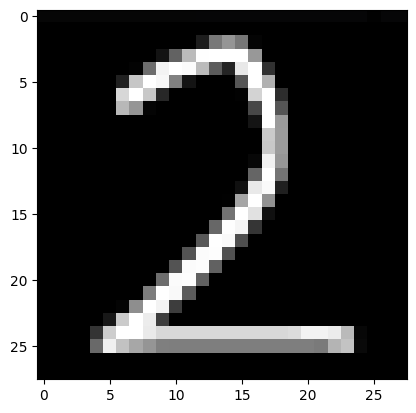

In [38]:
#we will draw using mouse/tablet/trackpad on any paint/art software and resize the image to size 28x28 pixels just like the mnist images
filepath = '/content/drive/MyDrive/Handwritten digit test images/hand-drawn 2.png'
image = mpimg.imread(filepath)
plt.imshow(image)

# the image is an rgb image and in png format, however our model takes tensors


1.   first we must convert pixel values of corrosponding rgb channels into greyscale values
2.   then we will convert the values obtained into a tensor (numpy ndarray)



(28, 28)
<class 'numpy.ndarray'>


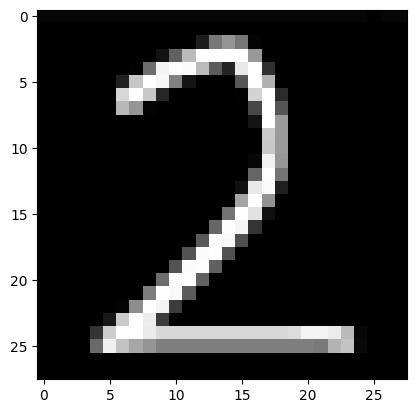

In [39]:
gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
plt.imshow(gray_image, cmap='gray')
print(gray_image.shape)
print(type(gray_image))

In [43]:
model.predict(gray_image.reshape(1,28,28,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[5.8521473e-12, 3.8934793e-09, 9.9999952e-01, 4.4222699e-07,
        1.1340004e-14, 3.4813019e-21, 1.4354629e-16, 5.5514970e-10,
        6.0231369e-11, 2.7203242e-15]], dtype=float32)

In [49]:
prediction = model.predict(gray_image.reshape(1,28,28,1))
maxx = -1
for preds in prediction[0]:
  if(preds > maxx):
    maxx = preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [51]:
index = np.where(prediction[0]==maxx)
print("Prediction is : ",index[0])

Prediction is :  [2]
